In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir('drive/MyDrive/Datasets/DE-Apartments')

In [3]:
# ! pip install "dask[complete]"

In [4]:
ls

apartment-rental-offers-in-germany.zip  immo_data.csv


In [5]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import plotly.express as px

from multiprocessing import Pool, cpu_count
import dask
import dask.dataframe as dd

In [6]:
pd.options.display.max_columns = 50
data = pd.read_csv('immo_data.csv')

In [7]:
DF = data.copy()
COLS = DF.columns

In [8]:
data.head()

,regio1,serviceCharge,heatingType,telekomTvOffer,telekomHybridUploadSpeed,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,scoutId,noParkSpaces,firingTypes,hasKitchen,geo_bln,cellar,yearConstructedRange,baseRent,houseNumber,livingSpace,geo_krs,condition,interiorQual,petsAllowed,street,streetPlain,lift,baseRentRange,typeOfFlat,geo_plz,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,garden,livingSpaceRange,regio2,regio3,description,facilities,heatingCosts,energyEfficiencyClass,lastRefurbish,electricityBasePrice,electricityKwhPrice,date
0,Nordrhein_Westfalen,245.00,central_heating,ONE_YEAR_FREE,NaN,False,False,6,4.62,10.0,840.0,1965.0,96107057,1.0,oil,False,Nordrhein_Westfalen,True,2.0,595.0,244,86.00,Dortmund,well_kept,normal,NaN,Sch&uuml;ruferstra&szlig;e,Schüruferstraße,False,4,ground_floor,44269,4.0,181.4,1.0,3.0,4,True,4,Dortmund,Schüren,Die ebenerdig zu erreichende Erdgeschosswohnun...,Die Wohnung ist mit Laminat ausgelegt. Das Bad...,NaN,NaN,NaN,NaN,NaN,May19
1,Rheinland_Pfalz,134.00,self_contained_central_heating,ONE_YEAR_FREE,NaN,False,True,8,3.47,10.0,NaN,1871.0,111378734,2.0,gas,False,Rheinland_Pfalz,False,1.0,800.0,NaN,89.00,Rhein_Pfalz_Kreis,refurbished,normal,no,no_information,NaN,False,5,ground_floor,67459,3.0,NaN,NaN,NaN,3,False,4,Rhein_Pfalz_Kreis,Böhl_Iggelheim,Alles neu macht der Mai – so kann es auch für ...,NaN,NaN,NaN,2019.0,NaN,NaN,May19
2,Sachsen,255.00,floor_heating,ONE_YEAR_FREE,10.0,True,True,8,2.72,2.4,1300.0,2019.0,113147523,1.0,NaN,False,Sachsen,True,9.0,965.0,4,83.80,Dresden,first_time_use,sophisticated,NaN,Turnerweg,Turnerweg,True,6,apartment,1097,3.0,NaN,3.0,4.0,3,False,4,Dresden,Äußere_Neustadt_Antonstadt,Der Neubau entsteht im Herzen der Dresdner Neu...,"* 9 m² Balkon\n* Bad mit bodengleicher Dusche,...",NaN,NaN,NaN,NaN,NaN,Oct19
3,Sachsen,58.15,district_heating,ONE_YEAR_FREE,NaN,False,True,9,1.53,40.0,NaN,1964.0,108890903,NaN,district_heating,False,Sachsen,False,2.0,343.0,35,58.15,Mittelsachsen_Kreis,NaN,NaN,NaN,Gl&uuml;ck-Auf-Stra&szlig;e,Glück-Auf-Straße,False,2,other,9599,3.0,86.0,3.0,NaN,3,False,2,Mittelsachsen_Kreis,Freiberg,Abseits von Lärm und Abgasen in Ihre neue Wohn...,NaN,87.23,NaN,NaN,NaN,NaN,May19
4,Bremen,138.00,self_contained_central_heating,NaN,NaN,False,True,19,2.46,NaN,903.0,1950.0,114751222,NaN,gas,False,Bremen,False,1.0,765.0,10,84.97,Bremen,refurbished,NaN,NaN,Hermann-Henrich-Meier-Allee,Hermann-Henrich-Meier-Allee,False,5,apartment,28213,3.0,188.9,1.0,NaN,3,False,4,Bremen,Neu_Schwachhausen,Es handelt sich hier um ein saniertes Mehrfami...,Diese Wohnung wurde neu saniert und ist wie fo...,NaN,NaN,NaN,NaN,NaN,Feb20


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268850 entries, 0 to 268849
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   regio1                    268850 non-null  object 
 1   serviceCharge             261941 non-null  float64
 2   heatingType               223994 non-null  object 
 3   telekomTvOffer            236231 non-null  object 
 4   telekomHybridUploadSpeed  45020 non-null   float64
 5   newlyConst                268850 non-null  bool   
 6   balcony                   268850 non-null  bool   
 7   picturecount              268850 non-null  int64  
 8   pricetrend                267018 non-null  float64
 9   telekomUploadSpeed        235492 non-null  float64
 10  totalRent                 228333 non-null  float64
 11  yearConstructed           211805 non-null  float64
 12  scoutId                   268850 non-null  int64  
 13  noParkSpaces              93052 non-null   f

In [10]:
data.describe()

,serviceCharge,telekomHybridUploadSpeed,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,scoutId,noParkSpaces,yearConstructedRange,baseRent,livingSpace,baseRentRange,geo_plz,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,livingSpaceRange,heatingCosts,lastRefurbish,electricityBasePrice,electricityKwhPrice
count,261941.000000,45020.0,268850.000000,267018.000000,235492.000000,2.283330e+05,211805.000000,2.688500e+05,93052.000000,211805.000000,2.688500e+05,268850.000000,268850.000000,268850.000000,268850.000000,162344.000000,217541.000000,171118.000000,268850.000000,268850.000000,85518.000000,80711.000000,46846.000000,46846.000000
mean,151.206113,10.0,9.791958,3.389001,28.804928,9.013315e+02,1966.400590,1.069697e+08,1.327634,3.714544,6.941294e+02,74.355548,3.765256,37283.022235,2.641261,114.749533,2.122405,3.572319,2.571542,3.070790,76.990866,2013.904536,89.113612,0.199769
std,308.295790,0.0,6.408399,1.964874,16.337151,3.323833e+04,46.992207,1.250093e+07,8.361403,2.738134,1.953602e+04,254.759208,2.214357,27798.037296,2.633440,61.653663,3.634934,6.375496,0.937594,1.407127,147.716278,10.963125,5.395805,0.009667
min,0.000000,10.0,0.000000,-12.330000,1.000000,0.000000e+00,1000.000000,2.887174e+07,0.000000,1.000000,0.000000e+00,0.000000,1.000000,852.000000,1.000000,0.100000,-1.000000,0.000000,1.000000,1.000000,0.000000,1015.000000,71.430000,0.170500
25%,95.000000,10.0,6.000000,2.000000,10.000000,4.698000e+02,1950.000000,1.066910e+08,1.000000,1.000000,3.380000e+02,54.000000,2.000000,9128.000000,2.000000,79.000000,1.000000,2.000000,2.000000,2.000000,54.000000,2012.000000,90.760000,0.191500
50%,135.000000,10.0,9.000000,3.390000,40.000000,6.500000e+02,1973.000000,1.111584e+08,1.000000,3.000000,4.900000e+02,67.320000,3.000000,38667.000000,3.000000,107.000000,2.000000,3.000000,3.000000,3.000000,70.000000,2017.000000,90.760000,0.198500
75%,190.000000,10.0,13.000000,4.570000,40.000000,9.850000e+02,1996.000000,1.137688e+08,1.000000,5.000000,7.990000e+02,87.000000,5.000000,57072.000000,3.000000,140.300000,3.000000,4.000000,3.000000,4.000000,90.000000,2019.000000,90.760000,0.205500
max,146118.000000,10.0,121.000000,14.920000,100.000000,1.575154e+07,2090.000000,1.157117e+08,2241.000000,9.000000,9.999999e+06,111111.000000,9.000000,99998.000000,999.990000,1996.000000,999.000000,999.000000,5.000000,7.000000,12613.000000,2919.000000,90.760000,0.227600


## 1.Data Cleaning

First things first, lets get rid of some unnecessary features. Lets check out categorical columns and check their unique value counts.

In [11]:
object_cols = [col for col in data.columns if data[col].dtype == 'O']
for col in object_cols:
    print(f'{col} : {data[col].nunique()}')
print(f'scoutId : {data["scoutId"].nunique()}')

regio1 : 16
heatingType : 13
telekomTvOffer : 3
firingTypes : 132
geo_bln : 16
houseNumber : 5510
geo_krs : 419
condition : 10
interiorQual : 4
petsAllowed : 3
street : 52373
streetPlain : 54490
typeOfFlat : 10
regio2 : 419
regio3 : 8684
description : 212621
facilities : 189526
energyEfficiencyClass : 10
date : 4
scoutId : 268850


I will drop all categorical features which a lot of unique values, because it will increase the dimentionality of feature space afte one-hot encoding. One can feature engineer columns like `facilities` and `description` with nlp, but since it is in Dutch, I just simply drop them. I need features like `regio2`, `regio3` and `geo_krs` to find duplicates, so I will drop them later.

In [12]:
print(f'features before drop: {data.shape[1]}')
data = data.drop(columns=['date', 'facilities', 'description', 'streetPlain',
                            'street', 'houseNumber', 'geo_bln', 'scoutId', 'firingTypes'])
print(f'features after drop: {data.shape[1]}')

features before drop: 49
features after drop: 40


In [13]:
data['totalRent'].describe()

count    2.283330e+05
mean     9.013315e+02
std      3.323833e+04
min      0.000000e+00
25%      4.698000e+02
50%      6.500000e+02
75%      9.850000e+02
max      1.575154e+07
Name: totalRent, dtype: float64

### Delete outliers of numerical features

It seems one step of z-score normalization is not enough to remove outliers. So I run it twice:

Step 1: records before drop: 268850


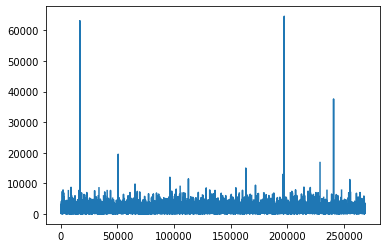

Step 1: records after drop: 255718
Elapsed time: 3.7851765155792236s.
----------
Step 2: records before drop: 255718


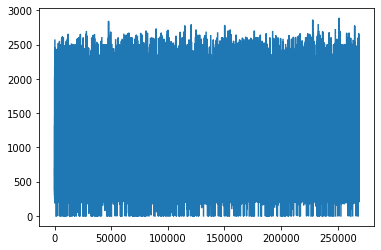

Step 2: records after drop: 247726
Elapsed time: 3.866992950439453s.
----------


In [14]:
for i, p in enumerate([3, 4]):
    print(f'Step {i+1}: records before drop: {data.shape[0]}')
    s_time = time.time()
    for cols in data.columns:
        if data[cols].dtype == 'int64' or data[cols].dtype == 'float64':
            upper_range = data[cols].mean() + p * data[cols].std()
            lower_range = data[cols].mean() - p * data[cols].std()
            
            indexs = data[(data[cols] > upper_range) | (data[cols] < lower_range)].index
            data = data.drop(indexs)
    data['totalRent'].plot()
    plt.show()
    print(f'Step {i+1}: records after drop: {data.shape[0]}')
    print(f'Elapsed time: {time.time()-s_time}s.')
    print(10*'-')

### Drop unnecessary null features
In this step I will explore percentage of null values in each feature. I will drop some of features that seems to be not useful. I will impute other ones later on.

In [15]:
null_percentage = data.isna().sum()/len(data) * 100
null_percentage = pd.DataFrame(data={'feature': null_percentage.index, 'null_percentage': null_percentage.values})
null_percentage = null_percentage[null_percentage['null_percentage'] > 0]
null_percentage['feature_type'] = null_percentage['feature'].apply(lambda x: str(data[x].dtype))
null_percentage = null_percentage.sort_values(by='null_percentage', ascending=False)

In [16]:
null_percentage

,feature,null_percentage,feature_type
39,electricityKwhPrice,84.166781,float64
38,electricityBasePrice,84.166781,float64
4,telekomHybridUploadSpeed,83.220574,float64
36,energyEfficiencyClass,70.915447,object
37,lastRefurbish,70.456876,float64
35,heatingCosts,68.365856,float64
12,noParkSpaces,66.152523,float64
21,petsAllowed,42.588989,object
20,interiorQual,42.177648,object
27,thermalChar,39.648644,float64


I will use `serviceCharge`, `electricityBasePrice` and `heatingCosts` to impute `totalRent` values, so I will fill their missing values with their mean (after deleting outliers). 
`electricityBasePrice` and `heatingCosts` have more than 50% missing values, so I will drop them after imputing `totalRent`.

In [17]:
data['serviceCharge'].fillna(data['serviceCharge'].mean(), inplace = True)
data['electricityBasePrice'].fillna(data['electricityBasePrice'].mean(), inplace = True)
data['heatingCosts'].fillna(data['heatingCosts'].mean(), inplace = True)

Let's drop other features that more than 50% of their records are missing.

In [18]:
print(f'Features before drop: {data.shape[1]}')
data = data.drop(columns=data.columns[((data.isnull().sum()/len(data)) > 0.50)])
print(f'Features after drop: {data.shape[1]}')

Features before drop: 40
Features after drop: 35


### Handling invalid values

First, lets remove records which their `living_space` and `totalRent` is 0. Since there's no null values in these columns and records with 0 value are few, droping them is a better choise.

In [19]:
print(f'{data[data.livingSpace == 0.0].shape[0]} entries with livingSpace = 0.')
print(f'{data[data.baseRent == 0.0].shape[0]} entries with baseRent = 0.')
print(f'{data[data.totalRent == 0.0].shape[0]} entries with totalRent = 0.')

64 entries with livingSpace = 0.
80 entries with baseRent = 0.
222 entries with totalRent = 0.


In [20]:
data = data.drop(data[data['livingSpace'] == 0.0].index)
data = data.drop(data[data['baseRent'] == 0.0].index)

Since some records have `totalRent` of 0 and this feature contains null values, it's better to fill zeros (meaningless values) with null.

In [21]:
print(f'Null values before fill: {data.totalRent.isnull().sum()}')
data['totalRent'] = data['totalRent'].replace(0, np.nan)
print(f'Null values after fill: {data.totalRent.isnull().sum()}')

Null values before fill: 37237
Null values after fill: 37452


### Removing duplicate values

In this step, I will use pandas `duplicated` module on features that has no null values, I think these features are more helpful for this task than features with null values.

In [22]:
duplicated = data.duplicated(subset=['geo_plz', 'geo_krs', 'livingSpace',
                        'baseRent', 'newlyConst', 'cellar', 
                        'balcony', 'garden', 'lift', 'noRooms',
                        'regio1', 'regio2', 'regio3', 'balcony'], keep=False)
duplicated_idx = duplicated[duplicated == True].index
print(f'We have {duplicated_idx.shape[0]} duplicated values which is {int(duplicated_idx.shape[0] * 100 / data.shape[0])}% of all data.')

We have 26034 duplicated values which is 10% of all data.


In [23]:
print(f'Records before duplicate drops: {data.shape[0]}')
data = data.drop(duplicated_idx)
print(f'Records after duplicate drops: {data.shape[0]}')

Records before duplicate drops: 247591
Records after duplicate drops: 221557


I don't need `regio2`, `regio3` and `geo_krs` anymore, so I'll drop them.

In [24]:
print(f'Features before drop: {data.shape[1]}')
data = data.drop(columns=['regio2', 'regio3', 'geo_krs'])
print(f'Features before drop: {data.shape[1]}')

Features before drop: 35
Features before drop: 32


### Impute missing values
First, let's impute the `totalRent` values. Filling this column with mean would be sloppy, so I will teorize a formula based on `baseRent`,  `serviceCharge`, `electricityBasePrice` and `heatingCosts`:
\begin{equation}
\text{totalRent} = \text{baseRent} + \text{serviceCharge} + \alpha \times \text{electricityBasePrice} + \beta \times \text{heatingCosts}
\end{equation}
I will figure out alpha and beta empirically. The distance between `baseRent` and `totalRent` means is 165. So I think other features should fill this gap.

In [25]:
int((data['totalRent'] - data['baseRent']).mean())

165

In [26]:
data['electricityBasePrice'].mean(), data['heatingCosts'].mean(), data['serviceCharge'].mean()

(90.76000000010441, 72.54129245728186, 146.33562772342697)

In [27]:
data['totalRent'].describe()

count    188112.000000
mean        775.667059
std         414.714748
min           1.000000
25%         475.000000
50%         650.000000
75%         964.000000
max        2885.830000
Name: totalRent, dtype: float64

In [28]:
data['totalRent'] = data.apply(
    lambda row: row['baseRent'] + row['serviceCharge'] + (1/7) * row['heatingCosts'] + (1/9) * row['electricityBasePrice'] if np.isnan(row['totalRent']) else row['totalRent'],
    axis=1
)

In [29]:
data['totalRent'].describe()

count    221557.000000
mean        777.555271
std         415.098338
min           1.000000
25%         477.000000
50%         654.500000
75%         968.000000
max        2885.830000
Name: totalRent, dtype: float64

As you can see, the mean and std of the column after imputation is close to the mean and std of the column before imputation. We don't need  `heatingCosts` and `electricityBasePrice` features anymore, so let's drop'em.

In [30]:
print(f'Features before drop: {data.shape[1]}')
data = data.drop(columns=['heatingCosts', 'electricityBasePrice'])
print(f'Features before drop: {data.shape[1]}')

Features before drop: 32
Features before drop: 30


In [31]:
data.isnull().sum()[data.isnull().sum()>0]

heatingType             36082
telekomTvOffer          26333
pricetrend               1593
telekomUploadSpeed      26923
yearConstructed         49016
yearConstructedRange    49016
condition               56246
interiorQual            91244
petsAllowed             92728
typeOfFlat              28894
thermalChar             90858
floor                   43407
numberOfFloors          80140
dtype: int64

Now let's impute other features, numerical features by their mean and categorical features by their mode.

In [32]:
data.fillna(data._get_numeric_data().mean(), inplace = True)

In [33]:
for cols in data.columns:
    if data[cols].dtype == 'object' or data[cols].dtype == 'bool':
        print('col: {}, mode value: {}'.format(cols , data[cols].value_counts().head(1).index[0]))
        data[cols].fillna(data[cols].value_counts().head(1).index[0], inplace = True)

col: regio1, mode value: Nordrhein_Westfalen
col: heatingType, mode value: central_heating
col: telekomTvOffer, mode value: ONE_YEAR_FREE
col: newlyConst, mode value: False
col: balcony, mode value: True
col: hasKitchen, mode value: False
col: cellar, mode value: True
col: condition, mode value: well_kept
col: interiorQual, mode value: normal
col: petsAllowed, mode value: negotiable
col: lift, mode value: False
col: typeOfFlat, mode value: apartment
col: garden, mode value: False


## 2.Data Visualization

In [34]:
for cols in data.columns:
    if data[cols].dtype == 'object' or data[cols].dtype == 'bool':
        print('col: {}, mode value: {}'.format(cols , data[cols].nunique()))

col: regio1, mode value: 16
col: heatingType, mode value: 13
col: telekomTvOffer, mode value: 3
col: newlyConst, mode value: 2
col: balcony, mode value: 2
col: hasKitchen, mode value: 2
col: cellar, mode value: 2
col: condition, mode value: 10
col: interiorQual, mode value: 4
col: petsAllowed, mode value: 3
col: lift, mode value: 2
col: typeOfFlat, mode value: 10
col: garden, mode value: 2


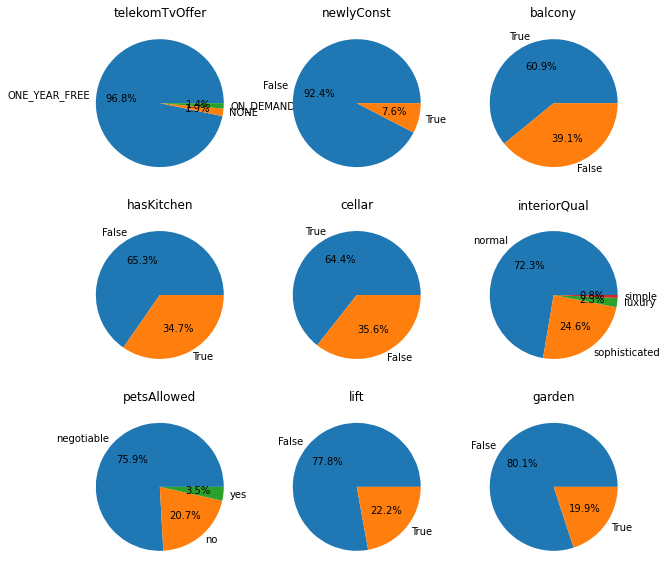

In [35]:
pie_cols = [
    'telekomTvOffer', 'newlyConst', 'balcony',
    'hasKitchen', 'cellar', 'interiorQual',
    'petsAllowed', 'lift', 'garden'
]

fig, axes= plt.subplots(3, 3, figsize=(10,10))

for i, ax in enumerate(axes.flatten()):
    vc = data[pie_cols[i]].value_counts()
    ax.pie(vc, labels=vc.index, autopct='%1.1f%%')
    ax.set_title(pie_cols[i])

plt.show()

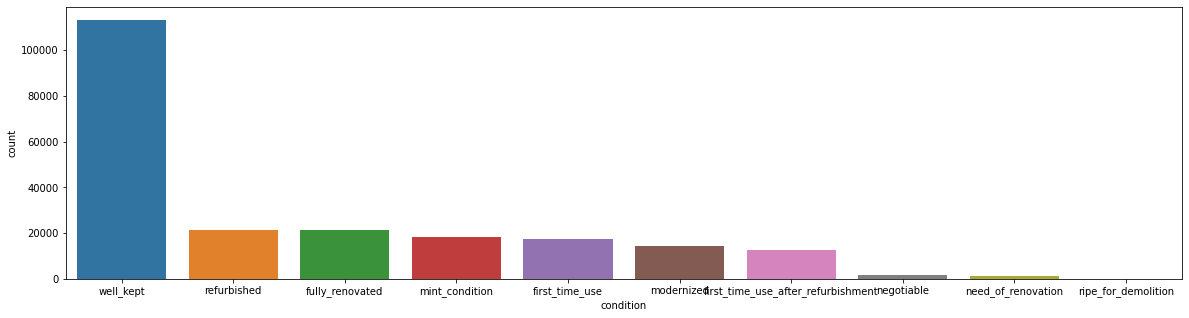

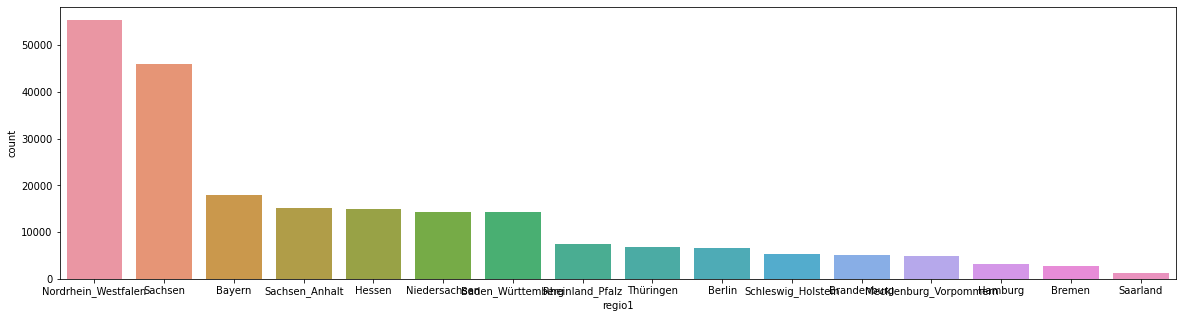

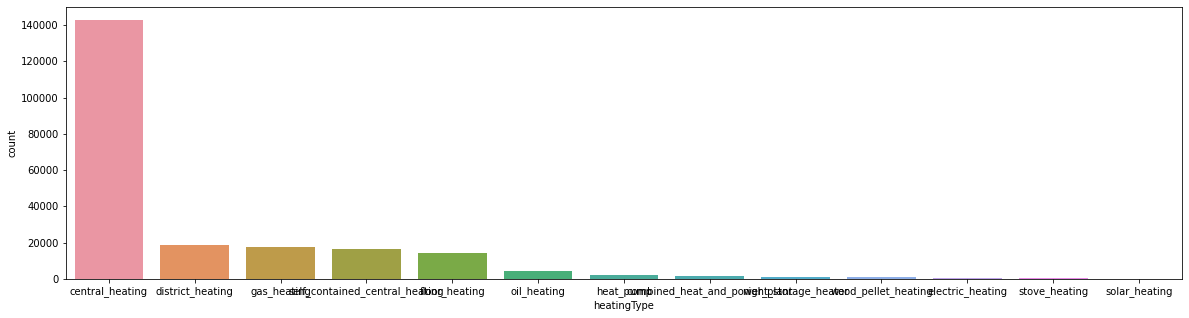

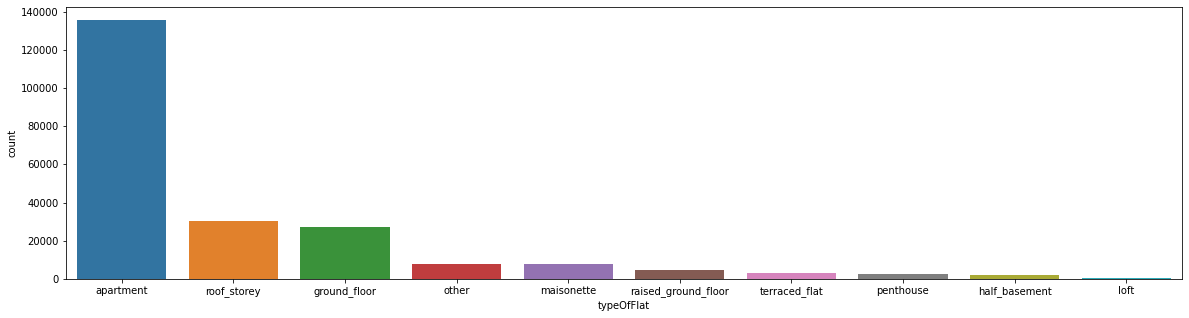

In [36]:
count_cols = ['condition', 'regio1', 'heatingType','typeOfFlat']
for col in count_cols:
    sns.countplot(x=data[col], order = data[col].value_counts().index);
    fig = plt.gcf()
    fig.set_size_inches(20, 5)
    plt.show()

To reduce features after one-hot encoding, I will reduce the number of categories thus reducing the dimentionality of final feature space.

In [37]:
def edit_condition(x):
    if x != 'well_kept':
        return 'other'
    else:
        return x

data['condition'] = data['condition'].apply(edit_condition)
data['condition'].value_counts()*100 / len(data)

well_kept    51.110549
other        48.889451
Name: condition, dtype: float64

In [38]:
def edit_heating(x):
    if x != 'central_heating':
        return 'other'
    else:
        return x

data['heatingType'] = data['heatingType'].apply(edit_heating)
data['heatingType'].value_counts()*100 / len(data)

central_heating    64.457453
other              35.542547
Name: heatingType, dtype: float64

In [39]:
top = list(data['typeOfFlat'].value_counts().head(3).index)
def edit_flat(x):
    if x not in top:
        return 'other'
    else:
        return x

data['typeOfFlat'] = data['typeOfFlat'].apply(edit_flat)
data['typeOfFlat'].value_counts()*100 / len(data)

apartment       61.187415
roof_storey     13.703020
other           12.826045
ground_floor    12.283521
Name: typeOfFlat, dtype: float64

In [40]:
rentmean_regio1 = data.groupby(['regio1'])['totalRent'].mean().sort_values(ascending=False)
rentmean_regio1

regio1
Hamburg                   1243.525535
Berlin                    1153.374006
Bayern                    1070.386332
Hessen                    1069.744001
Baden_Württemberg         1066.527073
Rheinland_Pfalz            840.716414
Schleswig_Holstein         811.774413
Bremen                     779.852738
Niedersachsen              752.612992
Nordrhein_Westfalen        749.724311
Saarland                   742.379756
Brandenburg                665.482656
Sachsen                    577.358275
Mecklenburg_Vorpommern     574.789969
Thüringen                  533.961770
Sachsen_Anhalt             516.338583
Name: totalRent, dtype: float64

In [41]:
fig = px.histogram(x = data['regio1'].value_counts().sort_index().index,
                   y = rentmean_regio1,
                   color= data['regio1'].value_counts().sort_index().index
             )
fig.update_xaxes(title="Region")
fig.update_yaxes(title = "Average totalRent")
fig.show()

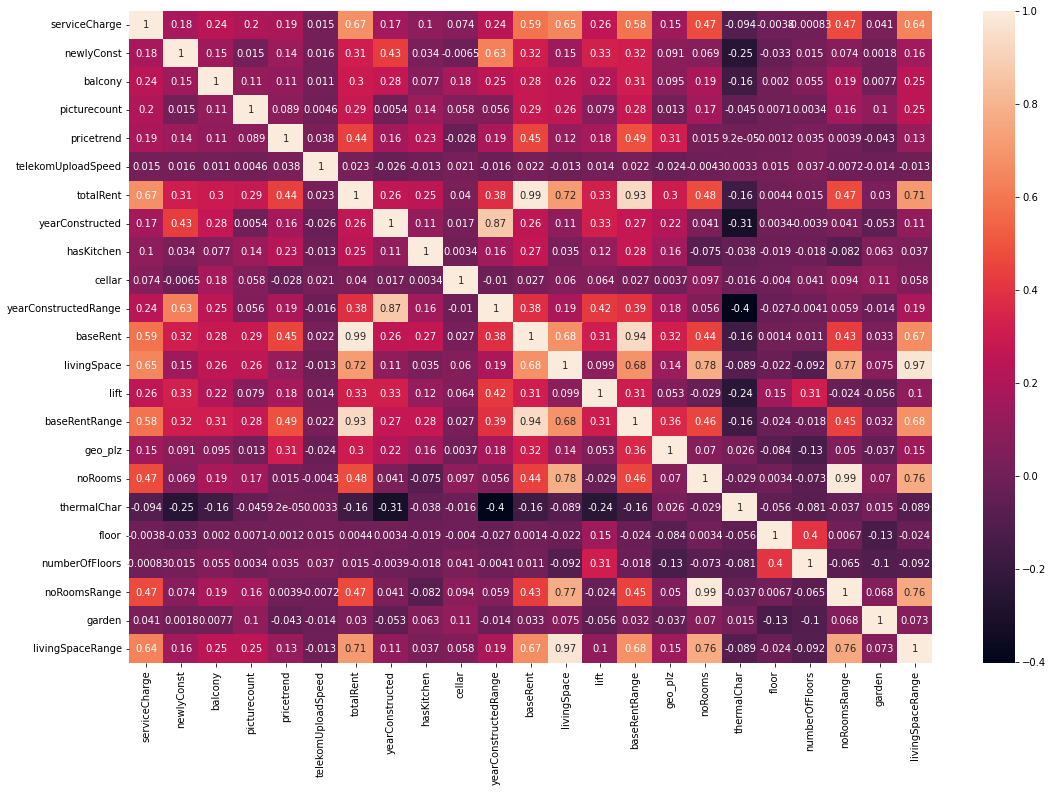

In [42]:
corr = data.corr()
plt.figure(figsize=(18,12))
sns.heatmap(corr, annot=True)

Some features have a high correlation with each other, so we can drop some features here.

In [43]:
data[['baseRent', 'baseRentRange']].corr()

,baseRent,baseRentRange
baseRent,1.000000,0.937255
baseRentRange,0.937255,1.000000


In [44]:
data[['noRooms', 'noRoomsRange']].corr()

,noRooms,noRoomsRange
noRooms,1.000000,0.985704
noRoomsRange,0.985704,1.000000


In [45]:
data[['yearConstructed', 'yearConstructedRange']].corr()

,yearConstructed,yearConstructedRange
yearConstructed,1.000000,0.870474
yearConstructedRange,0.870474,1.000000


In [46]:
data[['livingSpace', 'livingSpaceRange']].corr()

,livingSpace,livingSpaceRange
livingSpace,1.00000,0.97269
livingSpaceRange,0.97269,1.00000


These pair features are highly correlated and nearly identical. So I will drop either one of them.

In [47]:
print(f'Features before drop: {data.shape[1]}')
data = data.drop(columns=['livingSpaceRange', 'yearConstructedRange', 'baseRentRange', 'noRoomsRange'])
print(f'Features before drop: {data.shape[1]}')

Features before drop: 30
Features before drop: 26


## 3.Model
In this part I will train a model to predict `totalRent` after some data preprocessing. I will take 3 steps:
1. Encoding Boolean and Categorical Features
2. Data Split
3. Data Normalization
4. Training The Model

I will not one-hot encode boolean features, you can see why [here](https://stackoverflow.com/questions/43515877/should-binary-features-be-one-hot-encoded).

In [48]:
for col in ['newlyConst', 'balcony', 'hasKitchen', 'cellar', 'lift', 'garden']:
    data[col] = data[col].astype(int)

In [49]:
print(f'Features before encoding: {data.shape[1]}')
categoricals = []
for col in data.columns:
    if data[col].dtype == 'object':
        categoricals.append(col)

dummies_feature = pd.get_dummies(data[categoricals])
data = pd.concat([data, dummies_feature], axis=1)
data = data.drop(columns=categoricals)
print(f'Features after encoding: {data.shape[1]}')

Features before encoding: 26
Features after encoding: 53


In [50]:
data

,serviceCharge,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,hasKitchen,cellar,baseRent,livingSpace,lift,geo_plz,noRooms,thermalChar,floor,numberOfFloors,garden,regio1_Baden_Württemberg,regio1_Bayern,regio1_Berlin,regio1_Brandenburg,regio1_Bremen,regio1_Hamburg,...,regio1_Nordrhein_Westfalen,regio1_Rheinland_Pfalz,regio1_Saarland,regio1_Sachsen,regio1_Sachsen_Anhalt,regio1_Schleswig_Holstein,regio1_Thüringen,heatingType_central_heating,heatingType_other,telekomTvOffer_NONE,telekomTvOffer_ONE_YEAR_FREE,telekomTvOffer_ON_DEMAND,condition_other,condition_well_kept,interiorQual_luxury,interiorQual_normal,interiorQual_simple,interiorQual_sophisticated,petsAllowed_negotiable,petsAllowed_no,petsAllowed_yes,typeOfFlat_apartment,typeOfFlat_ground_floor,typeOfFlat_other,typeOfFlat_roof_storey
0,245.00,0,0,6,4.62,10.000000,840.000000,1965.000000,0,1,595.0,86.00,0,44269,4.0,181.400000,1.000000,3.000000,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0
1,134.00,0,1,8,3.47,10.000000,954.440045,1871.000000,0,0,800.0,89.00,0,67459,3.0,113.715498,1.960432,3.305847,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0
2,255.00,1,1,8,2.72,2.400000,1300.000000,2019.000000,0,1,965.0,83.80,1,1097,3.0,113.715498,3.000000,4.000000,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0
3,58.15,0,1,9,1.53,40.000000,423.695873,1964.000000,0,0,343.0,58.15,0,9599,3.0,86.000000,3.000000,3.305847,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0
4,138.00,0,1,19,2.46,28.832614,903.000000,1950.000000,0,0,765.0,84.97,0,28213,3.0,188.900000,1.000000,3.305847,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268844,80.00,0,0,12,2.58,2.400000,670.000000,1967.712068,0,0,590.0,85.00,0,45279,3.0,113.715498,3.000000,3.000000,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,1
268845,90.00,0,1,0,2.74,10.000000,910.000000,2016.000000,0,1,820.0,90.00,0,82390,3.0,113.715498,1.960432,3.305847,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1
268846,220.00,0,1,12,6.49,28.832614,1150.000000,1983.000000,1,0,930.0,115.00,0,68519,3.5,113.715498,1.000000,1.000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,1,0,0,1,0,0,0
268847,220.00,0,1,21,2.90,40.000000,930.000000,1965.000000,0,1,650.0,95.00,0,65552,4.0,160.770000,1.000000,2.000000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0


In [51]:
y = data['totalRent']
x = data.drop(columns = ['totalRent'])

In [52]:
print(x.shape)
print(y.shape)

(221557, 52)
(221557,)


In [53]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

In [54]:
scaler = StandardScaler()
scaler.fit(x_train)

StandardScaler()

In [55]:
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [56]:
pca = PCA(0.80)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

In [57]:
print(x_train_pca.shape)
print(x_test_pca.shape)

(199401, 28)
(22156, 28)


In [58]:
lr = LinearRegression()

I will normalize the target values in a way that they reside in the range(0,1) [link](https://stats.stackexchange.com/questions/70801/how-to-normalize-data-to-0-1-range). I will use min and max values from training targets to normalize test targets, since we don't know how they look like in real life.

In [59]:
y_train = np.array(y_train)
y_min = y_train.min()
y_max = y_train.max()
Y_train = (y_train - y_min) / (y_max - y_min)
Y_test = (y_test - y_min) / (y_max - y_min)

In [60]:
lr.fit(x_train_pca, Y_train)

LinearRegression()

In [61]:
y_predicted = lr.predict(x_test_pca)
mean_squared_error(y_predicted, Y_test)

0.002946634894696876

## 4.Multiprocessing

In [62]:
def outlier_delete(col_name, dataframe=DF):
  if dataframe[col_name].dtype == 'int64' or dataframe[col_name].dtype == 'float64':
    upper_range = dataframe[col_name].mean() + 3 * dataframe[col_name].std()
    lower_range = dataframe[col_name].mean() - 3 * dataframe[col_name].std()         
    indexs = dataframe[(dataframe[col_name] > upper_range) | (dataframe[col_name] < lower_range)].index
    dataframe.drop(indexs)

In [63]:
s_time = time.time()
for col in COLS:
  outlier_delete(col)
print(f'Elapsed time: {time.time()-s_time}s.')

Elapsed time: 3.296907424926758s.


In [64]:
s_time = time.time()
with Pool(cpu_count()) as p:
  p.imap(outlier_delete, COLS)
print(f'Elapsed time: {time.time()-s_time}s.')

Elapsed time: 0.2060871124267578s.


In [65]:
def fill_na(col_name, dataframe=DF):
    if dataframe[col_name].dtype == 'object' or dataframe[col_name].dtype == 'bool':
      dataframe[col_name].fillna(dataframe[col_name].value_counts().head(1).index[0])
    elif dataframe[col_name].dtype == 'int64' or dataframe[col_name].dtype == 'float64':
      dataframe[col_name].fillna(dataframe[col_name].mean())

In [66]:
s_time = time.time()
for col in COLS:
  fill_na(col)
print(f'Elapsed time: {time.time()-s_time}s.')

Elapsed time: 3.3570950031280518s.


In [67]:
s_time = time.time()
with Pool(cpu_count()) as p:
  p.imap(fill_na, COLS)
print(f'Elapsed time: {time.time()-s_time}s.')

Elapsed time: 0.20204472541809082s.


## 5. Dask

In [68]:
ddf = dd.from_pandas(DF, npartitions=1)

In [69]:
%%time
monthly_total = ddf.groupby(['regio1'])['totalRent'].mean().compute()

CPU times: user 117 ms, sys: 4.8 ms, total: 122 ms
Wall time: 167 ms


In [70]:
%%time
monthly_total = ddf.groupby(['regio1'])['totalRent'].mean()

CPU times: user 33 ms, sys: 81 µs, total: 33.1 ms
Wall time: 67 ms


In [71]:
%%time
monthly_total = DF.groupby(['regio1'])['totalRent'].mean()

CPU times: user 34.9 ms, sys: 1.72 ms, total: 36.6 ms
Wall time: 50.8 ms


Why this happened? Dask documentation under [Best Practices](https://docs.dask.org/en/stable/dataframe-best-practices.html) suggests that:

For data that fits into RAM, Pandas can often be faster and easier to use than Dask DataFrame. 

In [72]:
ddf = dd.from_pandas(DF, npartitions=2)

In [73]:
def outlier_delete_whole(dataframe):
  for col_name in dataframe.columns:
    if dataframe[col_name].dtype == 'int64' or dataframe[col_name].dtype == 'float64':
      upper_range = dataframe[col_name].mean() + 3 * dataframe[col_name].std()
      lower_range = dataframe[col_name].mean() - 3 * dataframe[col_name].std()         
      indexs = dataframe[(dataframe[col_name] > upper_range) | (dataframe[col_name] < lower_range)].index
      dataframe.drop(indexs)

In [74]:
s_time = time.time()
outlier_delete_whole(DF)
print(f'Elapsed time: {time.time()-s_time}s.')

Elapsed time: 5.5979719161987305s.


In [75]:
s_time = time.time()
with Pool(cpu_count()) as p:
  p.imap(outlier_delete_whole, [ddf.partitions[0], ddf.partitions[1]])
print(f'Elapsed time: {time.time()-s_time}s.')

Elapsed time: 0.22002625465393066s.
